# CSDS 491 Final Project Writeup
### Oleksii Fedorenko, Nicholas Kernan, Hiroki Nakayama





Below we import key libaries such as torch for key Pytorch functions (e.g. loading a model), PIL for handling/displaying images, and matplotlib for creating plots. 

In [21]:
import torch
from PIL import Image
from IPython.display import Image as show_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np

## Problem Motivation 

When we first formed our group, we knew we wanted to look into practical applications of Bayesian Neural Networks. We were interested in them because neural networks are commonly applied in AI and are behind many of its recent breakthroughs (for example, autonomous vehicle software, or even ChatGPT). Thus, implementing some type of a neural network would allow us to find modern, practical use cases. We therefore look into Bayesian networks, as they allow us to incorporate what we’ve learned in this class to account for uncertainty in a neural network and better understand their tradeoffs as compared to a traditional model. 

When looking for applications of Bayesian Neural Networks, we found the paper “A Comprehensive Guide to Bayesian Convolutional Neural Network with Variational Inference”. It covers the conceptual background behind Bayesian CNNs and discusses several potential applications, such as image classification. For our project, we decided to specifically focus on the application of Bayesian CNNs in image super-resolution. This seemed very applicable to everyday use - people are often upset with the quality of their photos and would appreciate enhancement tools. Image super-resolution can also be used, e.g. for allowing a doctor to make better diagnoses from medical images (which are often low resolution). 

The goal of our project was therefore to build a Bayesian CNN for image resolution and compare it with a traditional CNN. We consider our project successful if we are able to implement working prototypes for each of these approaches, and if we are able to draw fair comparisons between them using factors such as peak signal-to-noise ratio, training time, and a simple “eyeball” comparison of the images produced with both methods. 

## Explanation and Background 

Convolutional neural networks (CNNs) are types of neural networks that are commonly employed for image classification. They employ “kernels”, small matrices of weights that are applied over the image to produce subimages, which can be compiled by future layers to fit complex relationships between the input image and the output of the CNN (in our case, a larger image which ideally enhances the detail of the original). However, a common issue with neural networks is that due to their flexibility to fit many possible functions from input to output, if they are not given a sufficiently large and high-quality dataset, “overfitting” may occur where the network achieves good performance on the training data but does not generalize well to real examples outside of its training. 

One approach to addressing overfitting is by viewing model weights through a Bayesian framework: seeing a weight not as a singular value but as a posterior distribution over our degree of belief in what the value of the weight might be, given our data. With Bayesian inference we can start with a prior distribution p(f), representing our prior beliefs about which functions may have generated our data (where f is a function that maps inputs x to outputs y). 

The KL divergence is a measure of the difference between the prior and posterior distributions of the model parameters. In the context of using Bayesian CNNs for image super resolution, the KL divergence (Kullback-Leibler divergence) is calculated between the prior distribution and the approximate posterior distribution over the model parameters. 

During training, the KL divergence between the prior distribution and the posterior distribution of the model parameters is minimized. This is equivalent to maximizing the evidence lower bound (ELBO), which is a lower bound on the log marginal likelihood of the data. Maximizing the ELBO ensures that the model parameters are optimized in a way that balances the fit to the data and the complexity of the model. By minimizing the KL divergence, we can encourage the posterior distribution to be close to the prior distribution, which can help prevent overfitting and improve the generalization performance of the model.
	
In image super-resolution, an algorithm or CNN has an input image and produces from it an output image where the width and height has been increased by some upscale factor, and ideally the quality of the image will be improved. For CNN’s, training can be done by taking high resolution images, cropping them by the desired upscale factor, and running them through the CNN. The closer this output is to the original image, the lower the loss (an example loss function is the mean squared error between the original pixel values and predicted values). Thus, a CNN that can upscale cropped images to approximate the original, will ideally generalize to be able to upscale new images and improve their quality. 

As convolutional layers produce matrices of values (which may be thought of as sub-images), the final layers in a CNN for classification would typically be fully connected layers to condense these matrices into singular values (where e.g. one neuron may output the probability of the image belonging to a certain class). For image super-resolution, our architecture instead needs to combine sub-images into a single image that is an enlarged version of the original. Therefore, after the convolutions, the final layer is a PixelShuffle layer (see https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html). Essentially, with an upscale factor r, the last convolution layer needs to produce r*r sub-images that are the same size as the original image, and PixelShuffle will combine them into a single image that is r times as large as the original. 
[image of weights distribution]


## Approach and Rationale

The approach we took was to find a working prototype of a traditional CNN for super resolution, then adapt the Bayesian approach given in the paper to create an analogous Bayesian CNN. This was our approach because creating both models from scratch would be very time consuming and have a larger risk of producing no results (i.e., if they could not produce acceptable outputs). Because the paper includes code for Bayesian classification, but not super resolution, adapting their approach to an existing super resolution solution would demonstrate knowledge of the underlying concepts while keeping our project manageable. It also allows us to focus more intently on the possible comparisons to make between the two approaches. 

We found an implementation of a traditional CNN for super resolution in the paper “Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network”. Since the paper on the bayesian network did not provide code for the applications like image super resolution and GAN, we used the SRCNN paper as a reference to developing Bayesian CNN for image super resolution application. We used the description of layers to develop the Bayesian Network with the same structure, but with integrating Bayesian components like Bayesian layers that use distributions of weights instead of constant weights. We can see the layout of the network below:


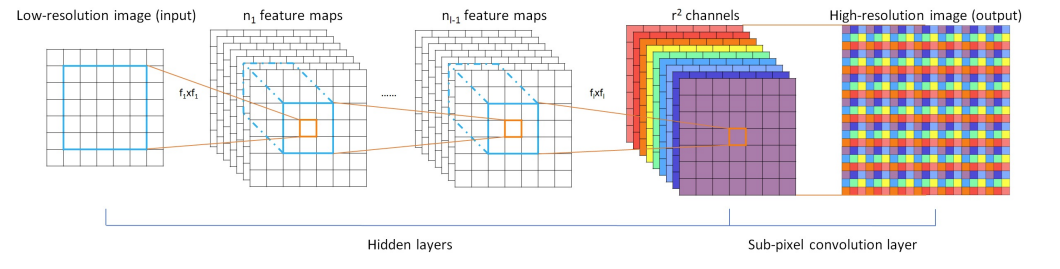

In [22]:
show_image(filename='./report_images/network_layers.png')


This image shows our proposed convolutional neural network, which includes two convolution layers for feature maps extraction and a sub-pixel convolution layer that aggregates the feature maps from low resolution to high resolution image in a single step. We employed a four-layer convolutional model similar to the CNN proposed in “Real-Time Single Image and Video Super-Resolution” paper, but with a Bayesian convolution layer replacing the standard convolution layer. In the forward pass, our approach computes the mean, variance, and KL divergence. The PixelShuffle layer remained unchanged and was provided by PyTorch.

Each of the images used for training and testing underwent a procedure where it was downscaled according to the specified `upscale_factor` and then the downscaled image was used as a network input where the network was supposed to learn how to upscale the image to the original, which serves as a target. The result of this procedure is that the input has increased resolution as specified by the `upscale_factor`. 

We decided to use PyTorch to implement our network because the original paper used PyTorch to implement Bayesian convolution layers that we used in our network implementation. PyTorch is also very flexible with the ability to write custom optimizers and loss functions which we thought could be useful to integrate the KL divergence that paper used as a part of the loss function. In code we named the traditional network `Net` and the bayesian network `BayesianNet`. 

One challenge of implementing the bayesian net was introducing nonlinearity since the original paper did not specify how they introduced non linearity layers and the convolutions were custom made so, we could not just use regular ReLU activation in the forward step like the traditional CNN did, so we had to introduce nonlinearity in the model definition itself. This is the suggested network layout by the paper:


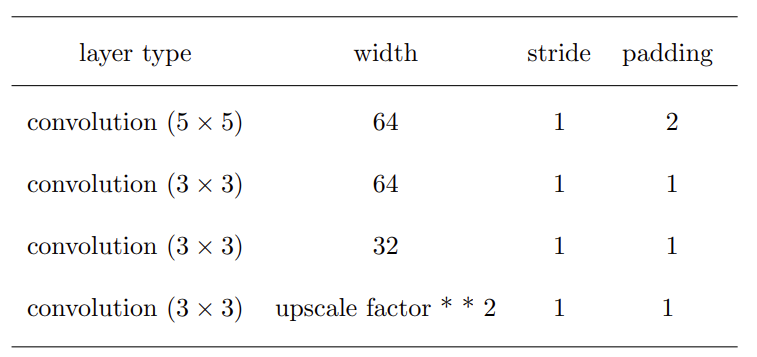

In [23]:
show_image(filename='./report_images/network_structure.png')


The original paper for Bayesian Networks suggested the ELBO loss function using KL divergence. KL divergence, also known as Kullback-Leibler divergence, is a measure of how different two probability distributions are from each other. In the context of Bayesian CNNs for image super-resolution, the KL divergence is used to measure the difference between the posterior distribution of the network weights and the prior distribution.

The ELBO loss function is a way to optimize a Bayesian neural network using stochastic variational inference. It combines the log-likelihood of the target outputs given the network outputs and the KL divergence between the posterior and prior distributions over the network weights. The ELBO loss is defined as the negative of the evidence lower bound, hence the name "ELBO" (evidence lower bound).

On the other hand, regular CNN used the MSE loss function. MSE stands for Mean Squared Error, which is a common loss function used in regression problems to measure the average squared difference between the predicted and actual values. In the context of image super-resolution using CNNs, MSE loss is used to measure the difference between the high-resolution target image and the low-resolution input image.

We tried implementing an ELBO loss function using log likelihood between the target and the output as well as introducing KL divergence into the loss function, as suggested by the paper. However the model seemed to perform a bit worse than just using the MSE, which is used by regular CNN. So, we decided to proceed with just the MSE loss function for further testing. 


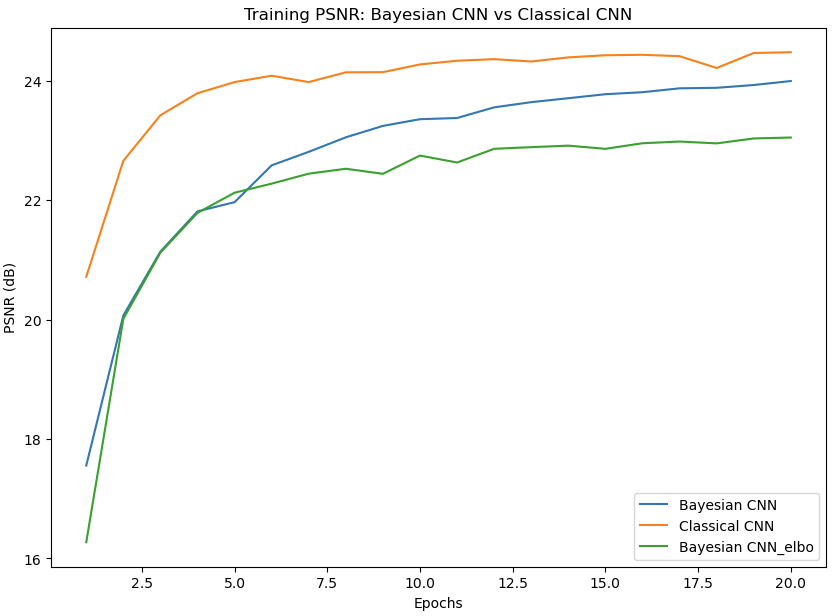

In [24]:
show_image(filename='./report_images/psnr_comp.png')


We picked two different image datasets for our project. One is BSD-300 (Berkeley Segmentation Dataset), one of the BSDs commonly used for super-resolution. BSD-300 consists of 300 images, divided into a training set of 200 photos and a test set of 100 prints. We picked this dataset because it contains a decent number of high-resolution images, each with different details and complexity. In addition, the dataset consists of various natural scenes and objects, making it useful for testing the performance of super-resolution algorithms. Another dataset we selected is the COCO (Common Objects In Context) dataset, a set of challenging, high-quality datasets for computer vision, primarily state-of-the-art neural networks. We picked this dataset because it contained a more significant number of images than BSD-300. The COCO dataset consists of 5000 images, divided into a training set of 500 images and a testing set of 4500 images. 

Traditional CNNs for super-resolution tasks are deterministic, meaning they produce a single output image for a given input image. However, Bayes CNNs can have a distribution of possible output images, each with a probability score that reflects the uncertainty in the prediction. This distribution of possible output images can be used to estimate the level of uncertainty in the super-resolution process and to obtain a more accurate representation of the input image. Moreover, Bayes CNNs can also be used to incorporate prior knowledge about the image into the learning process. This prior knowledge can be used to guide the network to produce images that match specific characteristics of the input image or to enforce constraints on the output image. This is particularly useful for super-resolution tasks where the high-resolution image is expected to have specific characteristics or features. Overall, Bayes CNNs can provide a more robust and accurate approach to super-resolution tasks by handling uncertainty and incorporating prior knowledge into the learning process.








## Results and Analysis

In this section, we walk through our code for performing super-resolution and displaying statistics captured while training. This assumes that training has already occurred in super_resolution_main.ipynb, which will store model variables after each epoch in "super_resolution/models" and related statistics (e.g. training time or psnr) in "stats/" so that they can quickly be loaded here. To keep this section manageable, we do not walk through the other parts of our code, but our full repository is available at https://github.com/fedorenkood/csds491_BayesianCNN (note: share this repo or make it public). 


We saved models trained both on the cpu and with cuda, since training with cuda was much faster but not all members of our group had a laptop which supported it. This switches to cuda only if it is available. 

In [25]:
if torch.cuda.is_available():
    device_name = 'cuda'
else:
    device_name = 'cpu'
    
device = torch.device(device_name)
print(device)

cuda


When models are trained, they will be saved under a different filename depending on their model name (Bayesian Net or Net), dataset (BSDS300 or COCO), epoch (1-30), upscale factor (2-4) and device name (cpu or cuda). The function below will load the desired model. 

In [26]:
def load_model(model_name, dataset, epoch, factor, device_name):
    #print(model.state_dict()['conv1.W_mu'][0])
    
    model = torch.load(f'super_resolution/models/{model_name}/{dataset}/epoch_{epoch}_upscale_factor_{factor}_device_{device_name}.pth').to(device)
    print(model)
    return model

bayes_cnn = load_model("BayesianNet", dataset='BSD300', epoch=100, factor=3, device_name=device_name)
classical_cnn = load_model("Net", dataset='BSD300', epoch=100, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


This helper method below is used to avoid duplicate code, as it is frequently called whenever we want to take a tensor or model output (y) and display it as an image. It assumes that the image has been split into three components for the YCbCr color format (y=luminosity, Cb=relative blue component and Cr=relative red component), as our model's output will be in the y component (below, that is scaled and clipped to be within the 0-255 range of valid color values). The cb and cr then from the original image are resized, to convert the upscaled image into the RGB (red, green, blue) format and display it. 

In [27]:
def convert_to_image(y, cb, cr, fname):
    out_img_y = y * 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    
    print('saved to ', fname)
    out_img.save(fname)
    plt.imshow(out_img)
    plt.show()

## Visual Comparison: Classical CNN vs Bayesian CNN

The function below is used for a visual demonstration of the effectiveness of two different models (in our case,  Bayesian and classical models). This is done by taking an image, cropping it according to an upscale factor, then trying to recreate the original using super resolution with both models. This allows us to not only compare the images produced not only between models, but to compare them with a theoretical "perfect" model that would be able to entirely recreate the original. 

Original image:
saved to  original_image.png


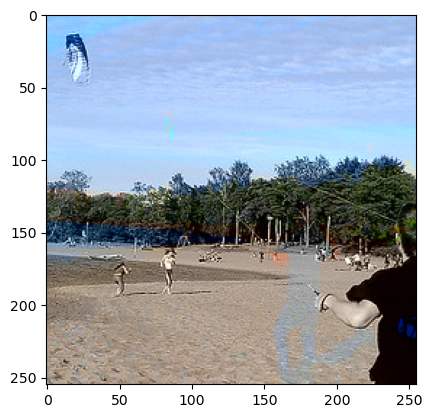

Cropped image:
saved to  cropped_image.png


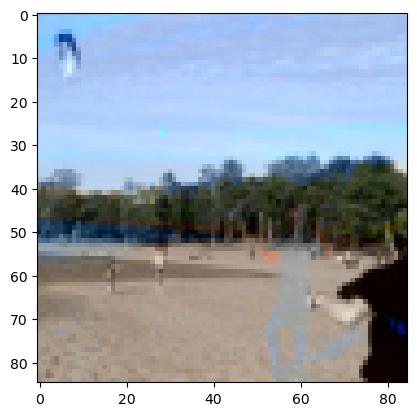

Upscaled cropped image with Net:
saved to  upscaled_cropped_image.png


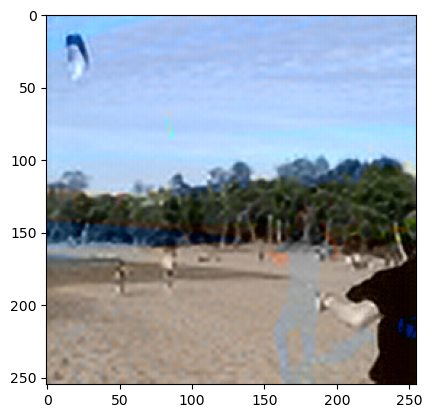

Upscaled cropped image with BayesianNet:
saved to  upscaled_cropped_image.png


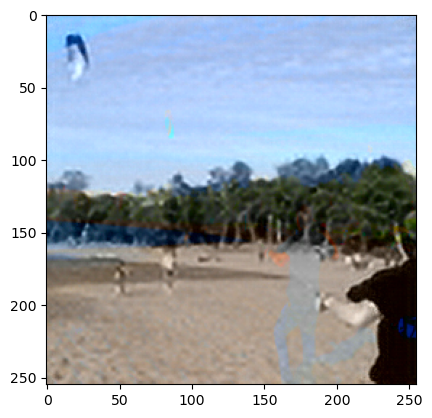

In [28]:
import os
from super_resolution.data import get_test_set

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def test_comparison(model1, model2, upscale_factor):
    test_set = get_test_set(upscale_factor, "BDSD300")

    input, target, cb, cr = test_set.getitem_full(74)

    print("Original image:")     
    convert_to_image(target, cb, cr, "original_image.png")
    
    
    print("Cropped image:")     
    convert_to_image(input, cb, cr, "cropped_image.png")
    
    for model in [model1, model2]:
        print(f"Upscaled cropped image with {model.__class__.__name__}:")
        t = torch.unsqueeze(input, dim=0).to(device)

        if 'Bayesian' in model.__class__.__name__:
            out, kl = model(t)
        else:
            out = model1(t)

        out = out.cpu()
        out = out[0].detach().numpy()

        convert_to_image(out, cb, cr, "upscaled_cropped_image.png")
    
test_comparison(classical_cnn, bayes_cnn, 3)

From an eyeball comparison of the Bayesian and classical CNNs, the upscaled images are {similar in quality to each other?}. They both show improvements over the cropped image, demonstrating that both models are "successful" prototypes in that they can recover some of the data loss and improve an image. However, since neither are able to fully capture the detail of the original image, there are likely still advancements to be made in image super resolution. 

## Stats Comparison: Classical CNN vs Bayesian CNN

Since there is little visual difference between the output of the Classical and Bayesian CNNs, we turn to the various metrics discussed in the Approach section to see if there is any reason to prefer one or the other. The cell below collects the statistics from when both models are trained, which are stored in a csv file and are converted to a dictionary for convenience (in the format: {Bayesian CNN: [20, 23, ...]} ). 

In [29]:
import csv
from collections import defaultdict

def get_stats(fname, model_names):
    
    stats = defaultdict(list)
    with open(fname, 'r') as data:
        for line in csv.DictReader(data):
            for name in model_names:
                stats[name].append(float(line[name]))
        
    return stats

The below is a helper function that will retrieve a stat from the above cell and plot it. 

In [30]:
def plot_stats(dataset, upscale_factor, total_epochs, stat, title, ylabel):
    model_names = ["Bayesian CNN", "Classical CNN"]
    fname = f"stats/{dataset}/upscale_{upscale_factor}__total_epocs_{total_epochs}_{stat}.csv"
    stats = get_stats(fname, model_names)

    plt.figure(figsize=(8, 6))
    plt.title(f"Classical vs Bayesian: {title}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    for name in model_names:
        plt.plot(range(1, total_epochs + 1), stats[name], label=name)
    plt.legend()
    plt.show()

Below, the training loss for Bayesian and Classical CNNs start out similar, but the final loss for Classical is superior, suggesting it does a better job of recreating the cropped training images. 

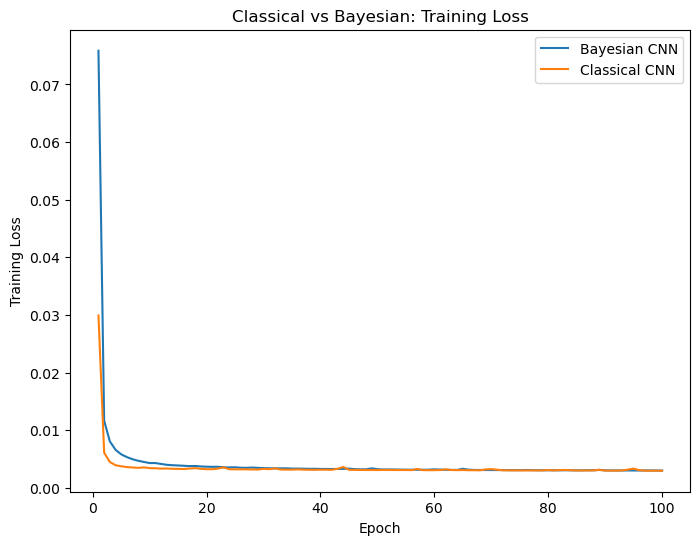

In [31]:
plot_stats("BSD300", 3, 100, "epoch_loss", "Training Loss", "Training Loss")

When plotting the PSNR, we see that the classical CNN has a better PSNR for each epoch. Since PSNR is evaluated over test data, this suggests that its superior training loss also leads to improved general performance in enhancing images. 

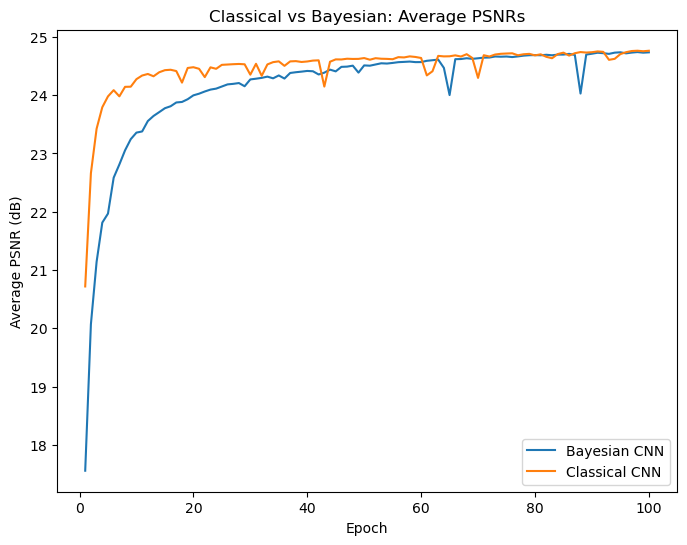

In [32]:
plot_stats("BSD300", 3, 100, "avg_psnrs", "Average PSNRs", "Average PSNR (dB)")

Finally, the training time elapsed for each epoch with both models is shown below. This should be taken with some skepticism as the time it might take for a epoch to complete is erratic (dependent e.g. on user device and current conditions). However, the intuitive answer is that the more complex nature of a Bayesian CNN would require more training time (needing to calculate both mean and variance for each weight), and this is confirmed by the plot below. 

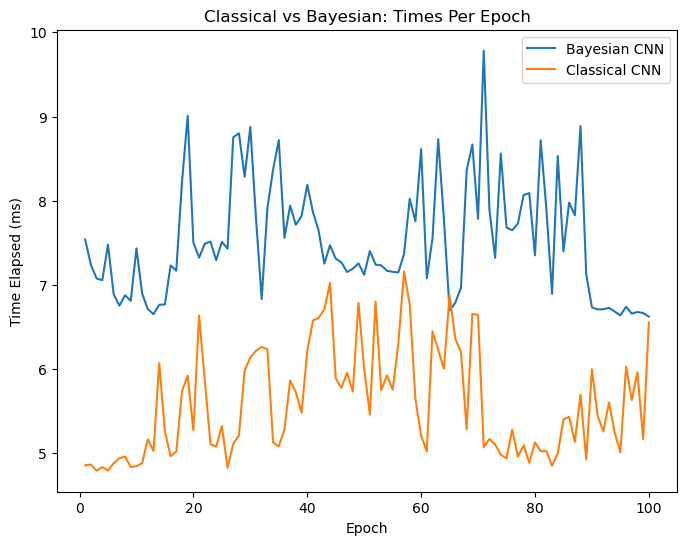

In [33]:
plot_stats("BSD300", 3, 100, "times", "Times Per Epoch", "Time Elapsed (ms)")

## Potential Reasons for using a Bayesian CNN?

Since our results thus far have indicated that one should generally prefer a classical CNN to a Bayesian CNN for super resolution, we wanted to see if there were any arguments in favor of pursuing a Bayesian CNN nonetheless. 
We read that a potential upside of Bayesian super-resolution is that since each weight has a mean and a variance, the variances could potentially be used to generate multiple valid super-resolutions for a single input image. 

When examining the forward function of the BBBConv class, we indeed notice in the following code sample that its outputs are stochastic:

````
    eps = torch.empty(act_mu.size()).normal_(0, 1).to(self.device)
    return act_mu + act_std * eps
````

However, we found that in practice, when sampled multiple times the resulting images did not look different enough to be noticeable to a person. Therefore, we added a new variable to BBBConv called variance_scale, which in the code sample above increases the variance in the normal sample (to be normal_(0, 1 * variance_scale)). This variable, which can be set in each layer in the function below, will artificially increase the differences between repeated samples (but still proportional to the model's own variance weights, after training) as a proof of concept to see if any interesting observations occur. 

In [34]:
def set_var_scale(model, scale):
    model.conv1.variance_scale = scale
    model.conv2.variance_scale = scale
    model.conv3.variance_scale = scale
    model.conv4.variance_scale = scale

The function below will upscale an image file, using a Bayesian model with the variance scale specified. 

In [35]:
def upscale_image(model, input_image, output_filename, variance_scale=1):
    img = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()

    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)
    
    model = model.cpu()
    set_var_scale(model, variance_scale)
    model = model.to(device)
    out, kl = model(input)
    out = out.cpu()
    out = out[0].detach().numpy()
    
    print("Image with variance scale of", variance_scale)
    fname = f"variance_{variance_scale}_{output_filename}"
    convert_to_image(out, cb, cr, fname)

Image with variance scale of 0
saved to  variance_0_out.png


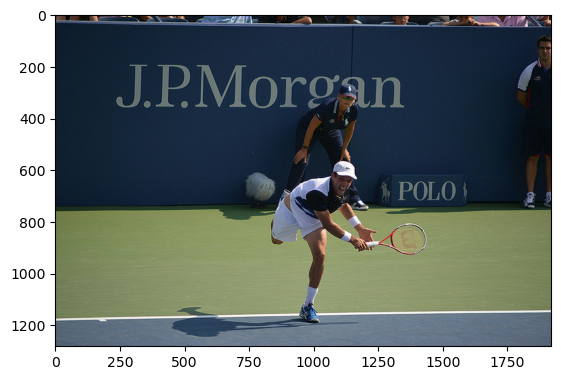

Image with variance scale of 1
saved to  variance_1_out.png


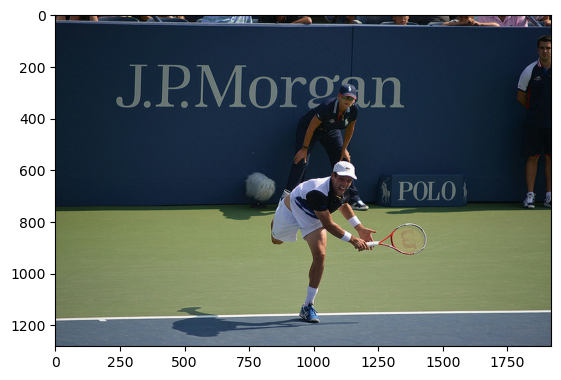

Image with variance scale of 2
saved to  variance_2_out.png


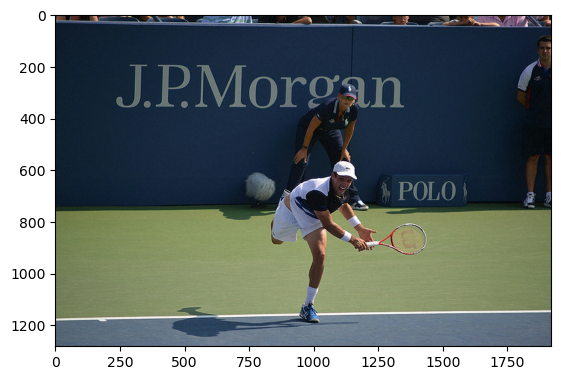

Image with variance scale of 5
saved to  variance_5_out.png


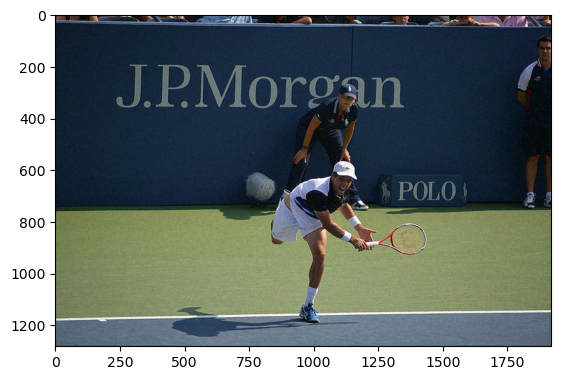

Image with variance scale of 100
saved to  variance_100_out.png


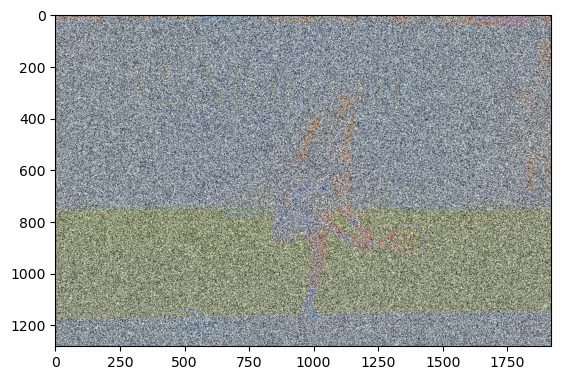

In [36]:
input_image = "./super_resolution/dataset/coco/images/test/000000000885.jpg" 
output_filename = "out.png"

for var_scale in [0, 1, 2, 5, 100]:
    upscale_image(bayes_cnn, input_image, output_filename, var_scale)

We see that higher variance factors do not seem to lead to interesting variations in the model output, and essentially just add more and more random noise (and with a scale of 100, any properties in the original image are lost). In hindsight, this was perhaps to be expected (as we are merely increasing the scale of the random values that will be added to each pixel), but it suggests that the variance weights in the model are not likely to lead to interesting new image creations (at least without some major changes to the model, such as perhaps a loss function which has multiple possible outputs in mind and takes the mean squared error from the one it is closest to). 

If given more time, another potential avenue to explore for why one might prefer a Bayesian CNN, is the paper's claim that they can reduce overfitting. To test this, we could see if the Bayesian CNN generalizes better when 

PS: imma be honest paper made this approach sound way better than it actually is. It should be called lossless scaling or something like that. 